# This script prepares the daily nowcasted data that can be supplied to the Rt model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pystan
import datetime
import arviz
import seaborn as sns
import scipy
sns.set()

In [3]:
from nowcasting_functions import *

## Load and prepare the data

In [7]:
# Load the data
data = pd.read_csv('data/df_SIVEP_nowcast_allStates_08-02-2021.csv')
def get_state_data(df, state):
    df_state = df.copy()
    if state == 'Brazil':
        df_state.drop(columns=['State'], inplace=True)
        columns = list(df_state.columns)
        columns.remove('Deaths')
        df_state = df_state.groupby(columns, as_index=False)['Deaths'].sum()
        return df_state
    return df_state[df_state['State'] == state]

data = get_state_data(data, 'Brazil')
max_D = 10

In [8]:
# Prepare the data for nowcast
data['Release_index'] = data.Release.astype('category').cat.codes
data = data[data['Date'] >= '2020-06-30'] # cut off early days as they are less relevant
data = data[data['Release'] >= '2020-06-30'] # cut off early days as they are less relevant
data

,Date,Release,Date_index,Release_index,Deaths
5760,2020-06-30,2020-07-07,181,0,722
5761,2020-06-30,2020-07-14,181,1,933
5762,2020-06-30,2020-07-21,181,2,1025
5763,2020-06-30,2020-07-29,181,3,1091
5764,2020-06-30,2020-08-03,181,4,1116
...,...,...,...,...,...
9446,2021-02-03,2021-02-08,399,31,621
9447,2021-02-04,2021-02-08,400,31,486
9448,2021-02-05,2021-02-08,401,31,353
9449,2021-02-06,2021-02-08,402,31,225


In [10]:
data_new = data.copy()
data_new = data_new[data_new['Release'] <= '2020-11-23'] # cut off early days as they are less relevant
data_new

,Date,Release,Date_index,Release_index,Deaths
5760,2020-06-30,2020-07-07,181,0,722
5761,2020-06-30,2020-07-14,181,1,933
5762,2020-06-30,2020-07-21,181,2,1025
5763,2020-06-30,2020-07-29,181,3,1091
5764,2020-06-30,2020-08-03,181,4,1116
...,...,...,...,...,...
8936,2020-11-19,2020-11-23,323,20,293
8948,2020-11-20,2020-11-23,324,20,188
8960,2020-11-21,2020-11-23,325,20,169
8972,2020-11-22,2020-11-23,326,20,149


## Compile and fit the model

In [11]:
model_4compSE = pystan.StanModel(file='stan_models/4comp_longshort_SE.stan')
print('Model compiled')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5fc993fd7bf0aedb8928d1ca1f5149e1 NOW.


Model compiled


In [8]:
fit_4compSE, results4compSE = fit_model(data_new, precompiled=False, modelname=model_4compSE, date_nowcast=None,
              maxD=10, iters=1000, warmup=400, chains=4, adapt_delta=0.9,
              max_treedepth=12, seed=9876,
              pickle_run=False, save=False, savepath='')

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [9]:
def plot_results(df, result_nowcast, show_x=True, show_y=True, show_legend=True):
    date_nowcast = df['Date'].values[-1]
    reported, _ = nowcasting_prep(df, date_nowcast, maxD=10)
    nowcasted = result_nowcast
    
    x = reported.index + 27

    plt.fill_between(x, y1=nowcasted['q025'].values,
                     y2=nowcasted['q975'].values, alpha = 0.3, 
                     label = '_95% CrI', color = 'orange')
    label = 'GP model nowcast' # '50% CrI'
    plt.fill_between(x, y1=nowcasted['q25'].values,
                     y2=nowcasted['q75'].values, alpha = 0.6, 
                     label = label, color = 'orange')

    plt.scatter(reported.index+27, reported.all_deaths.values, 
             label = 'reported', color='blue')

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    if show_x:
        plt.xlabel('Epidemiological week', fontsize=16)
    if show_y:
        plt.ylabel('Number of deaths per week', fontsize=16)
    if show_legend:
        plt.legend(loc="upper right", fontsize=12)
    plt.tight_layout()

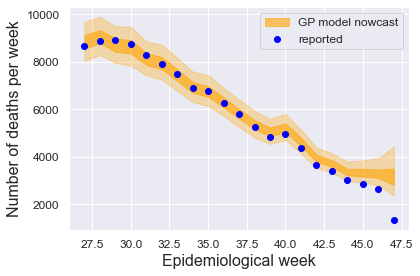

In [10]:
plot_results(data_new, results4compSE)

## Get the daily nowcasted values

In [31]:
now = '2020-11-23'

In [26]:
# Prepare the data for nowcasting
data_filtered = data_new[data_new['Release'] <= now].copy() # remove the data above nowcasting date

# 1. Change the Release index to start from 0
releases = np.sort(data_filtered.Release_index.unique())
for i in range(len(releases)):
    data_filtered.loc[data_filtered["Release_index"] == releases[i], "Release_index"] = i

# 2. Create a reporting triangle for the validation data
delays_data = create_reporting_triangle(data_filtered)

# 3. Sum up the deaths above max_D (maximum delay to be used)
delays_data = sum_up_delays_above_max(delays_data, max_D)

# 4. Bin the data into weeks
first_date = datetime.datetime.strptime(delays_data.index[0],'%Y-%m-%d')
last_date = datetime.datetime.strptime(delays_data.index[-1],'%Y-%m-%d')
delays_data['week'] = get_weeks_vector(len(delays_data))
delays_data

,0,1,2,3,4,5,6,7,8,9,10,week
2020-06-30,658,217,95,81,26,38,25,25,28,15,69,0
2020-07-01,621,225,94,67,15,46,27,30,21,14,57,0
2020-07-02,583,281,115,91,20,22,18,33,19,8,59,0
2020-07-03,446,297,127,82,18,34,29,29,18,18,101,0
2020-07-04,417,359,112,83,17,52,20,26,24,11,76,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-19,268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20
2020-11-20,167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20
2020-11-21,153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20
2020-11-22,128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20


In [34]:
# Prepare the data for validation -- only the most recent release, binned by weeks
data_validation_daily = data[data['Release_index'] == data['Release_index'].values[-1]].copy()
data_validation_daily.index = data_validation_daily['Date'].values
data_validation_daily.drop(columns = ['Date', 'Release', 'Date_index', 'Release_index'], inplace = True)
data_validation_daily.rename(columns={"Deaths": "all_deaths"}, inplace = True)
data_validation_daily['week'] = get_weeks_vector(len(data_validation_daily))

data_validation_daily

,all_deaths,week
2020-06-30,1294,0
2020-07-01,1232,0
2020-07-02,1264,0
2020-07-03,1223,0
2020-07-04,1215,0
...,...,...
2021-02-03,588,31
2021-02-04,458,31
2021-02-05,330,31
2021-02-06,213,31


In [35]:
# interpolate to get daily deaths rather than per week
nowcasted_data = results4compSE.copy()
nowcasted_data['mean_daily'] = nowcasted_data['mean'] / 7
nowcasted_data_daily = pd.DataFrame(columns = ['Date', 'Week', 'Deaths'])
nowcasted_data_daily['Date'] = delays_data.index
nowcasted_data_daily['Week'] = delays_data['week'].values.astype(int)

# in the nowcasted_data_daily set the mean daily deaths to happen on day 4 of each week
number_of_weeks = nowcasted_data_daily['Week'].values[-1]
for week in range(number_of_weeks+1):
    day_deaths = nowcasted_data[nowcasted_data['week'] == week]['mean_daily'].values[0] 
    middle_day = nowcasted_data_daily[nowcasted_data_daily['Week'] == week]['Date'].values[3] # this is the 4th day
    nowcasted_data_daily.loc[nowcasted_data_daily['Date'] == middle_day, 'Deaths'] = day_deaths

In [36]:
def interpolate_days(nowcasted_data, validation_data_daily, metric_midweek='mean', date_Rt=now, plot=True):
    """Takes in the weekly nowcasts of the data (nowcast_data) 
    and using the metric_midweek (mean, q25, q025, q75 or q975) gets interpolation of daily deaths
    up to date_Rt, which can be then used for the Rt model"""
    
    nowcasted_data['mean_daily'] = nowcasted_data[metric_midweek] / 7

    daily_data = validation_data_daily[validation_data_daily.index <= date_Rt]
    nowcasted_data_daily = pd.DataFrame(columns = ['Date', 'Week', 'Deaths'])
    nowcasted_data_daily['Date'] = daily_data.index
    nowcasted_data_daily['Week'] = daily_data['week'].values.astype(int)
    
    # in the nowcasted_data_daily set the mean daily deaths to happen on day 4 of each week
    number_of_weeks = nowcasted_data_daily['Week'].values[-1]
    for week in range(number_of_weeks+1):
#         print(week)
        day_deaths = nowcasted_data[nowcasted_data['week'] == week]['mean_daily'].values[0] 
        middle_day = nowcasted_data_daily[nowcasted_data_daily['Week'] == week]['Date'].values[3] # this is the 4th day
        nowcasted_data_daily.loc[nowcasted_data_daily['Date'] == middle_day, 'Deaths'] = day_deaths
    # now interpolate the rest
    x = np.array(nowcasted_data_daily.index.values, dtype=np.float64)
    y = np.array(nowcasted_data_daily['Deaths'].values, dtype=np.float64)

    x_known = x[np.argwhere(~np.isnan(y))].flatten()
    y_known = y[np.argwhere(~np.isnan(y))].flatten()

    spline = scipy.interpolate.splrep(x_known, y_known, k=1, s=2)
    # fill in the interpolated data
    nowcasted_data_daily_interpolated = nowcasted_data_daily.copy()
    values_interpolated = scipy.interpolate.splev(x, spline).astype(int)
    nowcasted_data_daily_interpolated['Deaths'] = values_interpolated
    
    if plot:
        plt.figure(figsize=[7,5])
        plt.plot(x_known, y_known, 'o',
                 x, validation_data_daily['all_deaths'].values[0:len(x)], '*',
                 x, values_interpolated, ':')
        plt.legend(['nowcasted mean', 'true', 'spline'], loc = 'best')

        plt.xlabel('Date index')
        plt.ylabel('Deaths')
        plt.title('Nowcasting per day using ' + metric_midweek)
        plt.show()
        
    return nowcasted_data_daily_interpolated

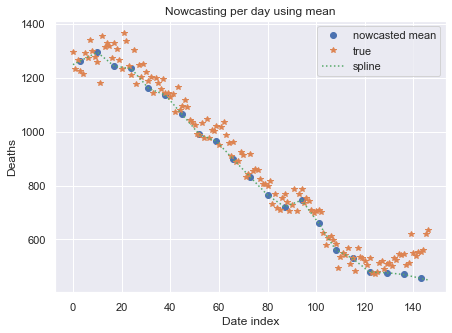

,Date,Week,Deaths
0,2020-06-30,0,1248
1,2020-07-01,0,1253
2,2020-07-02,0,1257
3,2020-07-03,0,1262
4,2020-07-04,0,1267
...,...,...,...
142,2020-11-19,20,458
143,2020-11-20,20,456
144,2020-11-21,20,454
145,2020-11-22,20,452


In [41]:
nowcasted_data_daily_interpolated = interpolate_days(nowcasted_data, data_validation_daily, 'mean', date_Rt=now, plot=True)
nowcasted_data_daily_interpolated

In [43]:
# Get variance for each GP prediction -- for the Rt model likelihood 
results_daily_row = pd.DataFrame(columns = nowcasted_data_daily_interpolated.index)
all_weekly = fit_4compSE.extract()['sum_n_predict']
for i in range(all_weekly.shape[0]):
    results = all_weekly[i,:]
    results_row = pd.DataFrame(columns = ['week','mean'])
    results_row['week'] = range(len(results))
    results_row['mean'] = results.astype(int)
    mean_interp_row = interpolate_days(results_row, data_validation_daily, 'mean', now, plot = False)
    results_daily_row = results_daily_row.append(pd.DataFrame(mean_interp_row['Deaths'].values).T)
                             
results_daily_row = results_daily_row.reset_index(drop=True)

nowcasted_data_daily_interpolated['Var'] = results_daily_row.var(axis=0)
nowcasted_data_daily_interpolated['Mean_all_samples'] = results_daily_row.mean(axis=0).astype(int)
nowcasted_data_daily_interpolated

C:\Users\iwona\anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:513: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


,Date,Week,Deaths,Var,Mean_all_samples
0,2020-06-30,0,1248,7811.608128,1248
1,2020-07-01,0,1253,6181.097113,1252
2,2020-07-02,0,1257,4820.346598,1257
3,2020-07-03,0,1262,3722.387505,1262
4,2020-07-04,0,1267,2885.937991,1266
...,...,...,...,...,...
142,2020-11-19,20,458,4675.394156,458
143,2020-11-20,20,456,5956.075195,456
144,2020-11-21,20,454,7465.146453,454
145,2020-11-22,20,452,9196.251269,452


In [44]:
# save the data to be used in the R_t model
today = pd.to_datetime('today').strftime('%Y-%m-%d')
savefile = 'nowcasted_daily_Brazil_23112020_' + today + '.csv'
nowcasted_data_daily_interpolated.to_csv(savefile)